In [2]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = r"C:\Users\aibel\Desktop\Heizel Ann Joseph\Parkinsons Disease"
DATA_ROOT = os.path.join(PROJECT_ROOT, "data", "PaHaW_dataset")
PAHAW_PUBLIC = os.path.join(DATA_ROOT, "PaHaW_public")

svc_files = sorted(glob.glob(os.path.join(PAHAW_PUBLIC, "*", "*.svc")))
print("Total .svc files:", len(svc_files))

sample_file = svc_files[0]
print("Using sample file:", sample_file)


Total .svc files: 597
Using sample file: C:\Users\aibel\Desktop\Heizel Ann Joseph\Parkinsons Disease\data\PaHaW_dataset\PaHaW_public\00001\00001__1_1.svc


In [3]:
def read_svc_file(path, normalize=False):
    data = np.loadtxt(path, skiprows=1)
    Y = data[:, 0]
    X = data[:, 1]
    T = data[:, 2] - np.min(data[:, 2])
    PEN = data[:, 3].astype(float)
    AZIM = data[:, 4]
    ALT = data[:, 5]
    PRESS = data[:, 6]
    
    if normalize:
        X = X - np.min(X)
        Y = Y - np.mean(Y)
        
    df = pd.DataFrame({
        "x": X,
        "y": Y,
        "time": T,
        "pen": PEN,
        "azim": AZIM,
        "alt": ALT,
        "press": PRESS
    })
    return df

print("read_svc_file ready.")


read_svc_file ready.


In [4]:
df_sample = read_svc_file(sample_file, normalize=True)
print("Loaded shape:", df_sample.shape)
df_sample.head()


Loaded shape: (1772, 7)


,x,y,time,pen,azim,alt,press
0,1430.0,-75.053047,0.0,1.0,3447.0,633.0,78.0
1,1428.0,-72.053047,7.0,1.0,3457.0,624.0,124.0
2,1428.0,-70.053047,15.0,1.0,3457.0,624.0,162.0
3,1427.0,-69.053047,22.0,1.0,3457.0,624.0,212.0
4,1427.0,-68.053047,30.0,1.0,3457.0,624.0,266.0


In [6]:
def ensure_time_in_seconds(df):
    df = df.copy().reset_index(drop=True)
    t = df['time'].astype(float).values
    dt = np.diff(t)
    if len(dt) == 0:
        scale = 1.0
    else:
        med = np.median(np.abs(dt))
        if med > 1e5:
            scale = 1e6 
        elif med > 1e2:
            scale = 1e3  
        else:
            scale = 1.0 
    df['time_s'] = (t - t.min()) / scale
    df['dt'] = np.diff(df['time_s'], prepend=0)
    return df

df_proc = ensure_time_in_seconds(df_sample)
df_proc.head()


,x,y,time,pen,azim,alt,press,time_s,dt
0,1430.0,-75.053047,0.0,1.0,3447.0,633.0,78.0,0.0,0.0
1,1428.0,-72.053047,7.0,1.0,3457.0,624.0,124.0,7.0,7.0
2,1428.0,-70.053047,15.0,1.0,3457.0,624.0,162.0,15.0,8.0
3,1427.0,-69.053047,22.0,1.0,3457.0,624.0,212.0,22.0,7.0
4,1427.0,-68.053047,30.0,1.0,3457.0,624.0,266.0,30.0,8.0


In [7]:
from scipy.signal import savgol_filter

def smooth_xy(df, window=7, poly=2):
    df = df.copy()
    if len(df) >= window:
        df["x_s"] = savgol_filter(df["x"], window, poly)
        df["y_s"] = savgol_filter(df["y"], window, poly)
    else:
        df["x_s"] = df["x"]
        df["y_s"] = df["y"]
    return df

def compute_kinematics(df):
    df = df.copy().reset_index(drop=True)
    t = df["time_s"].values
    x = df["x_s"].values
    y = df["y_s"].values
    
    vx = np.gradient(x, t)
    vy = np.gradient(y, t)
    df["vx"] = vx
    df["vy"] = vy
    df["speed"] = np.sqrt(vx**2 + vy**2)
    
    ax = np.gradient(vx, t)
    ay = np.gradient(vy, t)
    df["ax"] = ax
    df["ay"] = ay
    df["accel"] = np.sqrt(ax**2 + ay**2)
    
    jx = np.gradient(ax, t)
    jy = np.gradient(ay, t)
    df["jerk"] = np.sqrt(jx**2 + jy**2)
    
    return df

df_proc = smooth_xy(df_proc)
df_proc = compute_kinematics(df_proc)
df_proc.head()


,x,y,time,pen,azim,alt,press,time_s,dt,x_s,y_s,vx,vy,speed,ax,ay,accel,jerk
0,1430.0,-75.053047,0.0,1.0,3447.0,633.0,78.0,0.0,0.0,1429.666667,-74.695905,-0.146259,0.326531,0.357790,0.002608,-0.005697,0.006266,0.000083
1,1428.0,-72.053047,7.0,1.0,3457.0,624.0,124.0,7.0,7.0,1428.642857,-72.410190,-0.128005,0.286650,0.313932,0.002872,-0.006213,0.006845,0.000126
2,1428.0,-70.053047,15.0,1.0,3457.0,624.0,162.0,15.0,8.0,1427.785714,-70.481619,-0.102608,0.232228,0.253886,0.004021,-0.007090,0.008151,0.000056
3,1427.0,-69.053047,22.0,1.0,3457.0,624.0,212.0,22.0,7.0,1427.095238,-68.910190,-0.069274,0.180839,0.193654,0.002857,-0.007090,0.007644,0.000314
4,1427.0,-68.053047,30.0,1.0,3457.0,624.0,266.0,30.0,8.0,1426.809524,-67.862571,-0.063832,0.126417,0.141619,-0.000529,-0.004868,0.004896,0.000240


In [8]:
from scipy.signal import find_peaks

def segment_by_pen(df):
    pen = df["pen"].values
    strokes = []
    start = None
    for i, p in enumerate(pen):
        if p == 1 and start is None:
            start = i
        if p == 0 and start is not None:
            strokes.append((start, i-1))
            start = None
    if start is not None:
        strokes.append((start, len(df)-1))
    return strokes

def split_stroke_by_speed_minima(df, s, e, prom=0.05, dist=8):
    segment = df.iloc[s:e+1].reset_index(drop=True)
    speed = segment["speed"].values
    inv = -speed
    peaks, _ = find_peaks(inv, prominence=prom, distance=dist)
    if len(peaks) == 0:
        return [(s, e)]
    cuts = [s + p for p in peaks]
    intervals = []
    prev = s
    for c in cuts:
        intervals.append((prev, c))
        prev = c + 1
    intervals.append((prev, e))
    return intervals

pen_strokes = segment_by_pen(df_proc)
print("pen_strokes found:", len(pen_strokes))
pen_strokes[:10]


pen_strokes found: 1


[(0, 1771)]

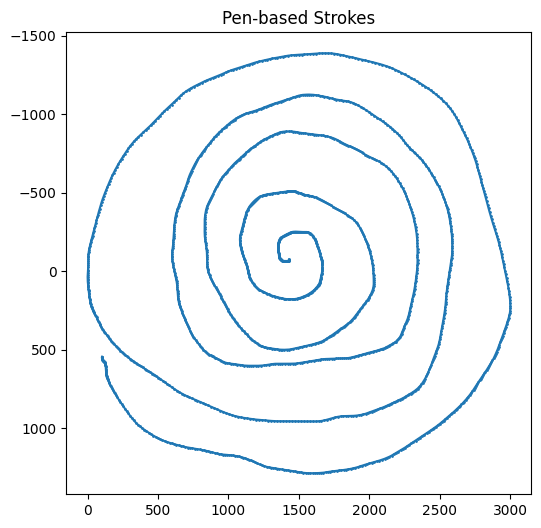

In [9]:
import itertools

def plot_strokes(df, strokes, title="Strokes"):
    plt.figure(figsize=(6,6))
    colors = itertools.cycle(plt.cm.tab20.colors)
    for (s, e) in strokes:
        c = next(colors)
        seg = df.iloc[s:e+1]
        plt.plot(seg["x_s"], seg["y_s"], "-", marker=".", color=c, markersize=2)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.show()

plot_strokes(df_proc, pen_strokes[:30], "Pen-based Strokes")
